# Imports

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import folium
import reverse_geocode
from datetime import datetime 
from haversine import haversine
from time import sleep
from pyproj import Geod

ModuleNotFoundError: No module named 'folium'

In [ ]:
df=pd.read_csv('../data/train.csv')

df.head()

In [ ]:
df.columns

# Crescimento

In [2]:
# 1. Quantidade de pedidos por dia.

df_aux = df.loc[:, ['delivery_id', 'order_date']].groupby('order_date').count().reset_index()
df_aux.columns = ['order_date', 'qtde_entregas']

px.bar(df_aux, x='order_date', y='qtde_entregas')

NameError: name 'df' is not defined

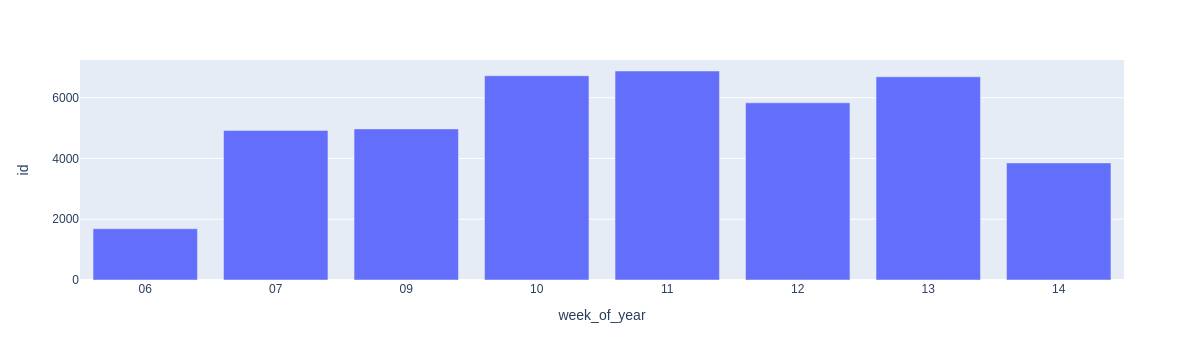

In [53]:
# 2. Quantidade de pedidos por semana.

# Quantidade de pedidos por Semana
df['week_of_year'] = df['order_date'].dt.strftime("%U")
df_aux = df.loc[:, ['delivery_id', 'week_of_year']].groupby('week_of_year').count().reset_index()

# gráfico
px.bar(df_aux, x='week_of_year', y='delivery_id')

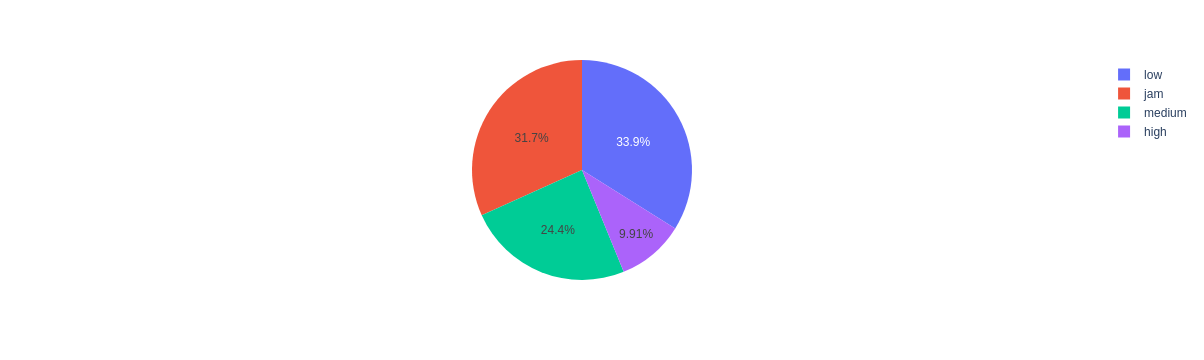

In [54]:
# 3. Distribuição dos pedidos por tipo de tráfego.

columns = ['delivery_id', 'road_traffic_density']
df_aux = df.loc[:, columns].groupby('road_traffic_density').count().reset_index()
df_aux['perc_delivery_id'] = 100 * (df_aux['delivery_id'] / df_aux['delivery_id'].sum())

# gráfico
px.pie(df_aux, values='perc_delivery_id', names='road_traffic_density')

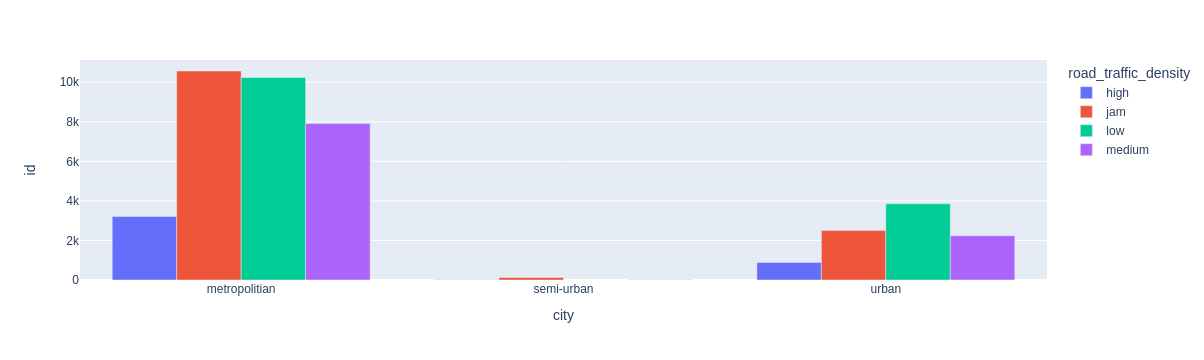

In [55]:
# 4. Comparação do volume de pedidos por tipo de cidade e tipo de tráfego.

columns = ['delivery_id', 'city_region', 'road_traffic_density']
df_aux = df.loc[:, columns].groupby(['city_region', 'road_traffic_density']).count().reset_index()
df_aux['perc_delivery_id'] = 100 * (df_aux['delivery_id'] / df_aux['delivery_id'].sum())

# gráfico
px.bar(df_aux, x='city_region', y='delivery_id', color='road_traffic_density', barmode='group')

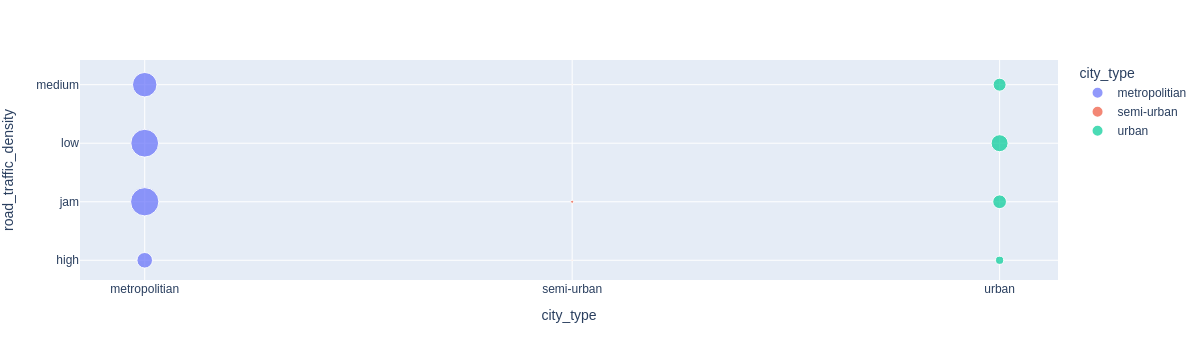

In [62]:
columns = ['delivery_id', 'city_region', 'road_traffic_density']
df_aux = df.loc[:, columns].groupby(['city_region', 'road_traffic_density']).count().reset_index()
df_aux['perc_delivery_id'] = 100 * (df_aux['delivery_id'] / df_aux['delivery_id'].sum())

px.scatter(df_aux,x='city_region',y='road_traffic_density',size='delivery_id',color='city_region')

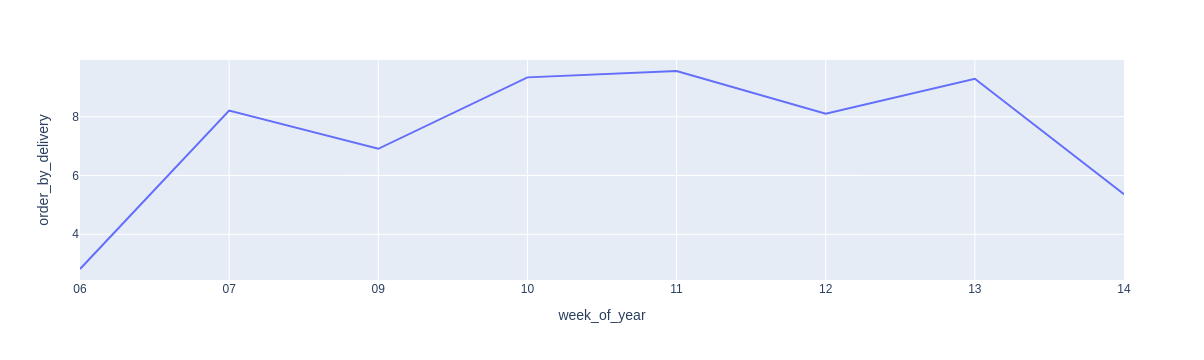

In [58]:
# 5. A quantidade de pedidos por entregador por semana.

# Quantidade de pedidos por entregador por Semana
df_aux1 = df.loc[:, ['delivery_id', 'week_of_year']].groupby('week_of_year').count().reset_index()
df_aux2 = df.loc[:, ['delivery_person_id', 'week_of_year']].groupby('week_of_year').nunique().reset_index()
df_aux = pd.merge(df_aux1, df_aux2, how='inner')

# Quantas entregas na semana / Quantos entregadores únicos por semana
df_aux['order_by_delivery'] = df_aux['delivery_id'] / df_aux['delivery_person_id']

# # gráfico
px.line(df_aux, x='week_of_year', y='order_by_delivery')

In [3]:
# 6. A localização central de cada cidade por tipo de tráfego.
columns = ['city_region', 'road_traffic_density', 'delivery_location_latitude','delivery_location_longitude']

columns_groupby = ['city_region', 'road_traffic_density']

data_plot = df.loc[:, columns].groupby(columns_groupby).median().reset_index()
data_plot = data_plot[data_plot['city_region'] != 'NaN']
data_plot = data_plot[data_plot['road_traffic_density'] != 'NaN']

# Desenhar o mapa
map_ = folium.Map(zoom_start=11)
for index, location_info in data_plot.iterrows():
    folium.Marker([location_info['delivery_location_latitude'],
    location_info['delivery_location_latitude']],
    popup=location_info[['city_region', 'road_traffic_density']]).add_to(map_)
    map_
map_

In [1]:
# df1=df[~df['city'].isin(['unknown'])]

# columns = ['city', 'road_traffic_density', 'delivery_location_latitude','delivery_location_longitude']

# columns_groupby = ['city', 'road_traffic_density']

# # data_plot = df.loc[:, columns].groupby(columns_groupby).median().reset_index()
# data_plot=df1[['city','road_traffic_density','restaurant_latitude','restaurant_longitude']]

# # Desenhar o mapa
# #map_ = folium.Map(zoom_start=11)
# #for index, location_info in data_plot.iterrows():
#     folium.Marker([location_info['restaurant_latitude'],
#     location_info['restaurant_latitude']],
#     popup=location_info[['city', 'road_traffic_density']]).add_to(map_)
#     map_
# map_

# Entregadores

In [8]:
# 1. A menor e maior delivery_idade dos entregadores.

print(df['delivery_person_age'].min())
print(df['delivery_person_age'].max())

20
39


In [21]:
# 2. A pior e a melhor condição de veículos.

print(df['vehicle_condition'].min())
print(df['vehicle_condition'].max())

0
2


In [24]:
# 3. A avaliação média por entregador.

df.groupby(['delivery_person_id'])['delivery_person_ratings'].mean().reset_index().sort_values(by='delivery_person_ratings')

,delivery_person_id,delivery_person_ratings
777,knpres20del01,4.300000
260,bhpres06del03,4.300000
847,kolres02del02,4.300000
65,alhres01del03,4.355556
281,bhpres14del03,4.388889
...,...,...
55,agrres19del02,4.840000
959,ludhres20del03,4.841667
497,goares05del03,4.842857
816,kocres13del01,4.861538


In [212]:
# 4. A avaliação média e o desvio padrão por tipo de tráfego.

df1=(df[['delivery_person_ratings','road_traffic_density']].groupby('road_traffic_density')
                                                          .agg(mean_=('delivery_person_ratings','mean'),
                                                              std_= ('delivery_person_ratings','std')).reset_index())

df1

,road_traffic_density,mean_,std_
0,high,4.652538,0.272699
1,jam,4.594428,0.329531
2,low,4.645947,0.337211
3,medium,4.660335,0.273956


In [211]:
# 5. A avaliação média e o desvio padrão por condições climáticas.

df1=(df[['delivery_person_ratings','weather_conditions']].groupby('weather_conditions')
                                                         .agg(mean_=('delivery_person_ratings','mean'),
                                                              std_= ('delivery_person_ratings','std')).reset_index())

df1

,weather_conditions,mean_,std_
0,cloudy,4.651945,0.281016
1,fog,4.653087,0.274974
2,sandstorms,4.612144,0.310527
3,stormy,4.612569,0.312621
4,sunny,4.656164,0.395057
5,windy,4.616844,0.304087


In [46]:
df4=df[['delivery_person_id','city','time_taken(min)']].groupby(['city','delivery_person_id']).mean().sort_values(
                                                                                                      'time_taken(min)').reset_index().drop_duplicates(subset='city',ignore_index=True)

df4

,city,delivery_person_id,time_taken(min)
0,kalamassery,kocres16del03,18.750000
1,unknown,dehres20del03,19.125000
2,kolkata,kolres06del03,19.444444
3,cavelossim,goares14del01,20.000000
4,dehra dūn,dehres17del01,20.000000
5,nawābganj,knpres01del01,20.200000
6,ludhiāna,ludhres18del02,20.333333
7,bhopal,bhpres15del03,20.500000
8,bara bazar,kolres14del02,20.615385
9,cochin,kocres08del03,21.000000


In [30]:
# 6. Os 10 entregadores mais rápidos por cidade.

# df['order_time']=(df['time_order_picked']-df['time_orderd'])
# df['order_time'].dt.components.minutes
# df['order_time']=df['order_time'].dt.components.minutes
# df[['time_orderd','time_order_picked','order_time']].head()

df1=df[['delivery_person_id','city_region','time_taken(min)']].groupby(
                                           ['city_region','delivery_person_id']).mean().sort_values(
                                           ['city_region','time_taken(min)']).reset_index()
df1

df2=df1[df1['city_region']=='metropolitian'].head(10)
df3=df1[df1['city_region']=='urban'].head(10)
df4=df1[df1['city_region']=='semi-urban'].head(10)

df5=pd.concat([df2,df3,df4])
df5

,city,delivery_person_id,time_taken(min)
0,metropolitian,knpres03del02,15.750000
1,metropolitian,alhres02del02,17.800000
2,metropolitian,knpres01del01,19.125000
3,metropolitian,kolres01del03,19.125000
4,metropolitian,kocres02del02,19.250000
5,metropolitian,kocres08del03,19.800000
6,metropolitian,kocres16del03,20.000000
7,metropolitian,kocres02del03,20.375000
8,metropolitian,goares14del01,20.400000
9,metropolitian,dehres20del03,20.428571


In [31]:
# 7. Os 10 entregadores mais lentos por cidade.

df1=df[['delivery_person_id','city_region','time_taken(min)']].groupby(
                                                       ['city_region','delivery_person_id']).mean().sort_values(
                                                       ['city_region','time_taken(min)'],ascending=False).reset_index()
df1

df2=df1[df1['city_region']=='metropolitian'].head(10)
df3=df1[df1['city_region']=='urban'].head(10)
df4=df1[df1['city_region']=='semi-urban'].head(10)

df5=pd.concat([df2,df3,df4])
df5

,city,delivery_person_id,time_taken(min)
1423,metropolitian,agrres02del01,39.428571
1424,metropolitian,aurgres11del03,38.500000
1425,metropolitian,kolres03del03,38.142857
1426,metropolitian,ludhres17del03,37.000000
1427,metropolitian,alhres18del02,36.666667
1428,metropolitian,goares08del03,36.000000
1429,metropolitian,alhres12del01,35.000000
1430,metropolitian,agrres13del02,34.700000
1431,metropolitian,knpres06del01,34.555556
1432,metropolitian,alhres010del01,34.500000


# Restaurante

In [24]:
# 1. A Quantidade de entregadores únicos.

print(f'A quantidade de entregadores únicos é : {len(df["delivery_person_id"].unique())}')

A quantidade de entregadores únicos é : 1320


In [5]:
# 2. A distância média dos resturantes e dos locais de entrega.

df1 = df[~df.isin([-23.5489]).any(axis=1)].copy()

# wgs84_geod = Geod(ellps='WGS84') # Distance will be measured on this ellipsodelivery_id - more accurate than a spherical method

# #Get distance between pairs of lat-lon points
# def Distance(lat1,lon1,lat2,lon2):
#   az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2)
#   return dist

# df1['dist'] = Distance(df1.loc[:,'restaurant_latitude'].tolist()       ,df1.loc[:,'restaurant_longitude'].tolist(),
#                        df1.loc[:,'delivery_location_latitude'].tolist(),df1.loc[:,'delivery_location_longitude'].tolist())


cols=['restaurant_latitude','restaurant_longitude','delivery_location_latitude','delivery_location_longitude']

df1['distance']=df1.loc[:,cols].apply(lambda x: haversine ((x['restaurant_latitude'],        x['restaurant_longitude']),
                                                        (x['delivery_location_latitude'], x['delivery_location_longitude'])),
                                                         axis=1)

# print(f' the mean distance between restaurants and delivery places in kilometers is {df1["dist"].mean().round() / 1000}')
print(f' the mean distance between restaurants and delivery places in kilometers is {df1["distance"].mean().round()}')

 the mean distance between restaurants and delivery places in kilometers is 10.0


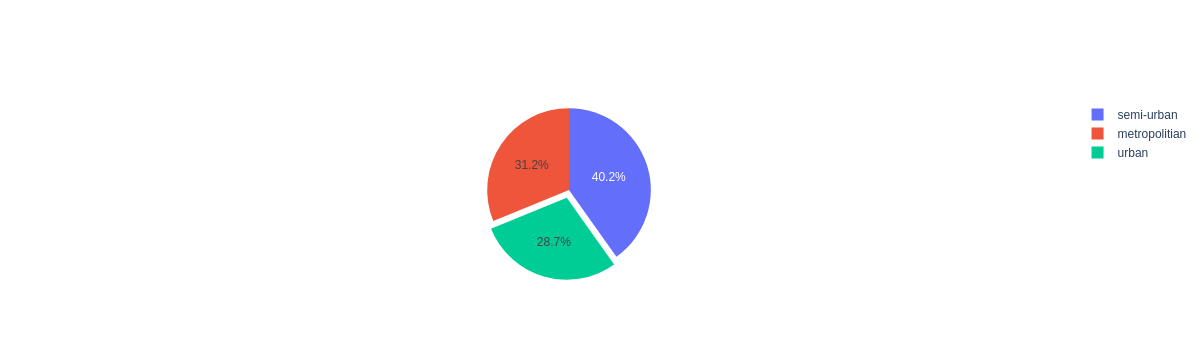

In [32]:
dist=df1[['city_region','distance']].groupby('city_region').mean().reset_index()

fig=go.Figure(data=[go.Pie (labels=dist['city_region'], values=dist['distance'], pull=[0,0,0.1])])
fig.show()

In [37]:
# 3. O tempo médio e o desvio padrão de entrega por cidade.

df1=(df[['city_region','time_taken(min)']].groupby(['city_region']).agg(mean_=('time_taken(min)','mean'),
                                                                 std_= ('time_taken(min)','std')).sort_values('mean_',ascending=True).reset_index())

df1

,city_region,mean_,std_
0,urban,23.209495,8.859189
1,metropolitian,27.429860,9.134286
2,semi-urban,49.710526,2.724992


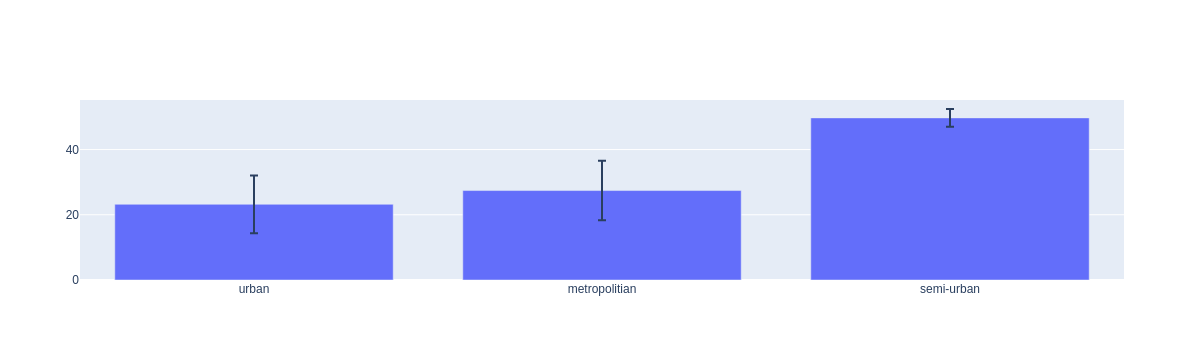

In [38]:
fig=go.Figure()
fig.add_trace(go.Bar(name='Control',x=df1['city_region'],y=df1['mean_'],error_y=dict(type='data',array=df1['std_'])))
fig.update_layout(barmode='group')
fig.show()

In [50]:
# 4. O tempo médio e o desvio padrão de entrega por cidade e tipo de pedido.

df1=(df[['city_region','type_of_order','time_taken(min)']].groupby(['city_region','type_of_order']).agg(mean_=('time_taken(min)','mean'),
                                                                 std_= ('time_taken(min)','std')).reset_index())

df1

,city_region,type_of_order,mean_,std_
0,metropolitian,buffet,27.301935,9.155644
1,metropolitian,drinks,27.324962,9.041698
2,metropolitian,meal,27.618877,9.215624
3,metropolitian,snack,27.467867,9.119682
4,semi-urban,buffet,49.707317,2.731702
5,semi-urban,drinks,49.625000,2.459347
6,semi-urban,meal,50.300000,3.041665
7,semi-urban,snack,49.408163,2.707385
8,urban,buffet,23.566337,9.060933
9,urban,drinks,23.308885,8.925721


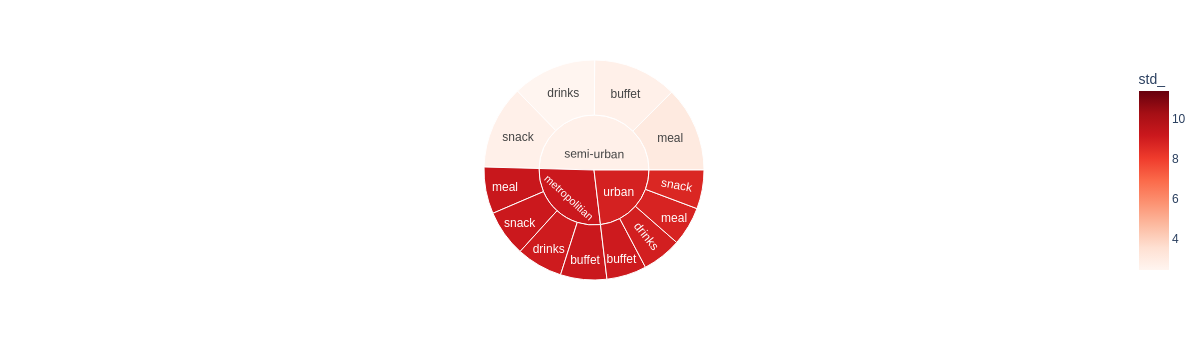

In [53]:
fig=px.sunburst(df1,path=['city_region','type_of_order'],values='mean_', color='std_', color_continuous_scale='Reds',
                                                                 color_continuous_midpoint=np.average(df1['std_']))

fig.show()

In [55]:
# 5. O tempo médio e o desvio padrão de entrega por cidade e tipo de tráfego.

df1=(df[['city_region','road_traffic_density','time_taken(min)']].groupby(['city_region','road_traffic_density'])
                                                         .agg(mean_=('time_taken(min)','mean'),
                                                              std_= ('time_taken(min)','std')).reset_index())

df1

,city_region,road_traffic_density,mean_,std_
0,metropolitian,high,28.145976,7.904494
1,metropolitian,jam,31.978193,9.477798
2,metropolitian,low,22.259874,6.795802
3,metropolitian,medium,27.728045,8.309769
4,semi-urban,high,50.125000,2.629956
5,semi-urban,jam,49.841270,2.717095
6,semi-urban,medium,47.400000,2.011080
7,urban,high,24.305335,8.494842
8,urban,jam,27.989541,10.078679
9,urban,low,19.445964,6.319847


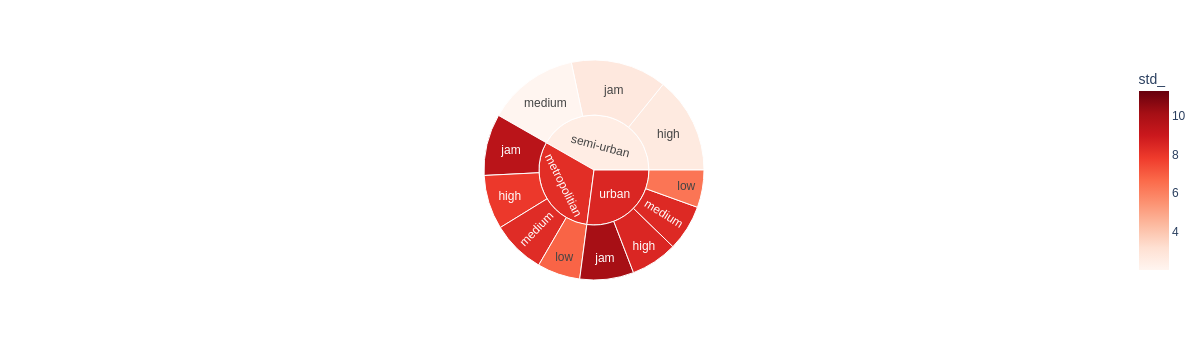

In [56]:
fig=px.sunburst(df1,path=['city_region','road_traffic_density'],values='mean_', color='std_', color_continuous_scale='Reds',
                                                                 color_continuous_midpoint=np.average(df1['std_']))

fig.show()

In [7]:
# 6. O tempo médio de entrega durantes os Festivais.

# df1=df[df['festival']==1]
# df1['time_taken(min)'].mean()

df1=(df[['festival','time_taken(min)']].groupby(['festival']).agg(mean_=('time_taken(min)','mean'),
                                                                  std_= ('time_taken(min)','std')).reset_index())

df1

,festival,mean_,std_
0,no,26.163612,9.002668
1,yes,45.518607,4.005399


In [8]:
df1=df1.loc[df1['festival']=='yes','mean_']
np.round(df1)

1    46.0
Name: mean_, dtype: float64

In [85]:
# df_raw=pd.read_csv('../data/train_raw.csv')

# df_raw.columns= df_raw.columns.str.lower()

# df_raw=df_raw.rename(columns={'id':'delivery_id'})
# df_raw=df_raw.rename(columns={'weatherconditions':'weather_conditions'})
# df_raw=df_raw.rename(columns={'city':'city_region'})

# df_raw = df_raw[~df_raw.isin(['NaN ']).any(axis=1)]

# df_raw['delivery_person_id']=df_raw['delivery_person_id'].replace(' ', '', regex=True).str.lower()

# df_raw['delivery_person_age']=df_raw['delivery_person_age'].astype(int)

# df_raw['delivery_person_ratings']=df_raw['delivery_person_ratings'].astype(float).replace({'  ':0})

# df_raw['restaurant_latitude']=df_raw['restaurant_latitude'].astype(str)
# df_raw['restaurant_latitude']=df_raw['restaurant_latitude'].replace('-','',regex=True)
# df_raw['restaurant_longitude']=df_raw['restaurant_longitude'].astype(str)
# df_raw['restaurant_latitude']=df_raw['restaurant_latitude']  .apply(lambda x: '-23.5489'  if x == '0.0' else x)
# df_raw['restaurant_longitude']=df_raw['restaurant_longitude'].apply(lambda x: '-46.6388'  if x == '0.0' else x)

# coords = tuple(zip(df_raw['restaurant_latitude'], df_raw['restaurant_longitude']))
# location = reverse_geocode.search(coords)
# city = [x.get('city') for x in location]
# df_raw['city'] = city
# df_raw['city']=df_raw['city'].apply(lambda x: 'Unknown'  if x == 'São Paulo' else x).str.lower()

# df_raw['order_date']=pd.to_datetime(df_raw['order_date'],format='%d-%m-%Y')

# # df_raw['time_orderd']=pd.to_datetime(df_raw['time_orderd'])

# # df_raw['time_order_picked']=pd.to_datetime(df_raw['time_order_picked'])

# df_raw['weather_conditions']=df_raw['weather_conditions'].replace(' ', '_', regex=True).str.lower()
# df_raw['weather_conditions']=df_raw['weather_conditions'].replace('conditions_', '', regex=True)

# df_raw['road_traffic_density']=df_raw['road_traffic_density'].replace(' ', '', regex=True).str.lower()

# df_raw['type_of_order']=df_raw['type_of_order'].replace(' ', '', regex=True).str.lower()

# df_raw['type_of_vehicle']=df_raw['type_of_vehicle'].replace(' ', '', regex=True)

# df_raw['multiple_deliveries']=df_raw['multiple_deliveries'].astype(int)

# df_raw['festival']=df_raw['festival'].replace(' ', '', regex=True).str.lower()

# df_raw['city_region']=df_raw['city_region'].replace(' ', '', regex=True).str.lower()

# df_raw['time_taken(min)']=df_raw['time_taken(min)'].replace('(min)', '', regex=True)
# df_raw['time_taken(min)']=df_raw['time_taken(min)'].replace('\(\)', '', regex=True)
# df_raw['time_taken(min)']=df_raw['time_taken(min)'].astype(int)
